In [176]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.morphology import dilation, square
from itertools import product
import geopandas as gpd
import cf_xarray as cfxr

In [178]:
import sys

In [369]:
from utils import (
    RCM_DICT,
    MODEL_DICT,
    RLAT_NAMES,
    RLON_NAMES,
)

from urban_areas import (
    load_fixed_variables,
    fix_sftuf,
    select_name,
    Urban_vicinity,
    load_variable,
    kelvin2degC,
    load_ucdb_city,
)

### Define urban areas and vicinity

##### Define model and data directory

In [180]:
domain = 'EUR-11'
model = 'REMO' # REMO/RegCM
scenario = 'evaluation'
variable = 'tasmin'
root_esgf = '/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/'
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'

##### Input parameters

In [329]:
lon_city = 2.35 
lat_city = 48.85
#lon_city = 14.26
#lat_city = 40.85
urban_th = 0.1
urban_sur_th = 0.1
orog_diff = 100
sftlf_th = 70
scale = 2
lon_lim = 0.7
lat_lim = 0.7

In [330]:
# domain resolution
res = int(domain.split('-')[1])

##### Load fixed variables

In [331]:
ds_sftuf, ds_orog, ds_sftlf = load_fixed_variables(domain, model, root_esgf, root_nextcloud)
# fix some issues for sftuf
ds_sftuf = fix_sftuf(domain, model, ds_sftuf, ds_orog, ds_sftlf)

##### Add parameters to the function

In [332]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim)

##### Crop area around de city

In [333]:
ds_sftuf = URBAN.crop_area_city(ds_sftuf, res)
ds_orog = URBAN.crop_area_city(ds_orog, res)
ds_sftlf = URBAN.crop_area_city(ds_sftlf, res)

##### Define masks

In [334]:
# define masks
sftuf_mask, sftuf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sftuf, 
    ds_orog, 
    ds_sftlf
)

##### Plot masks

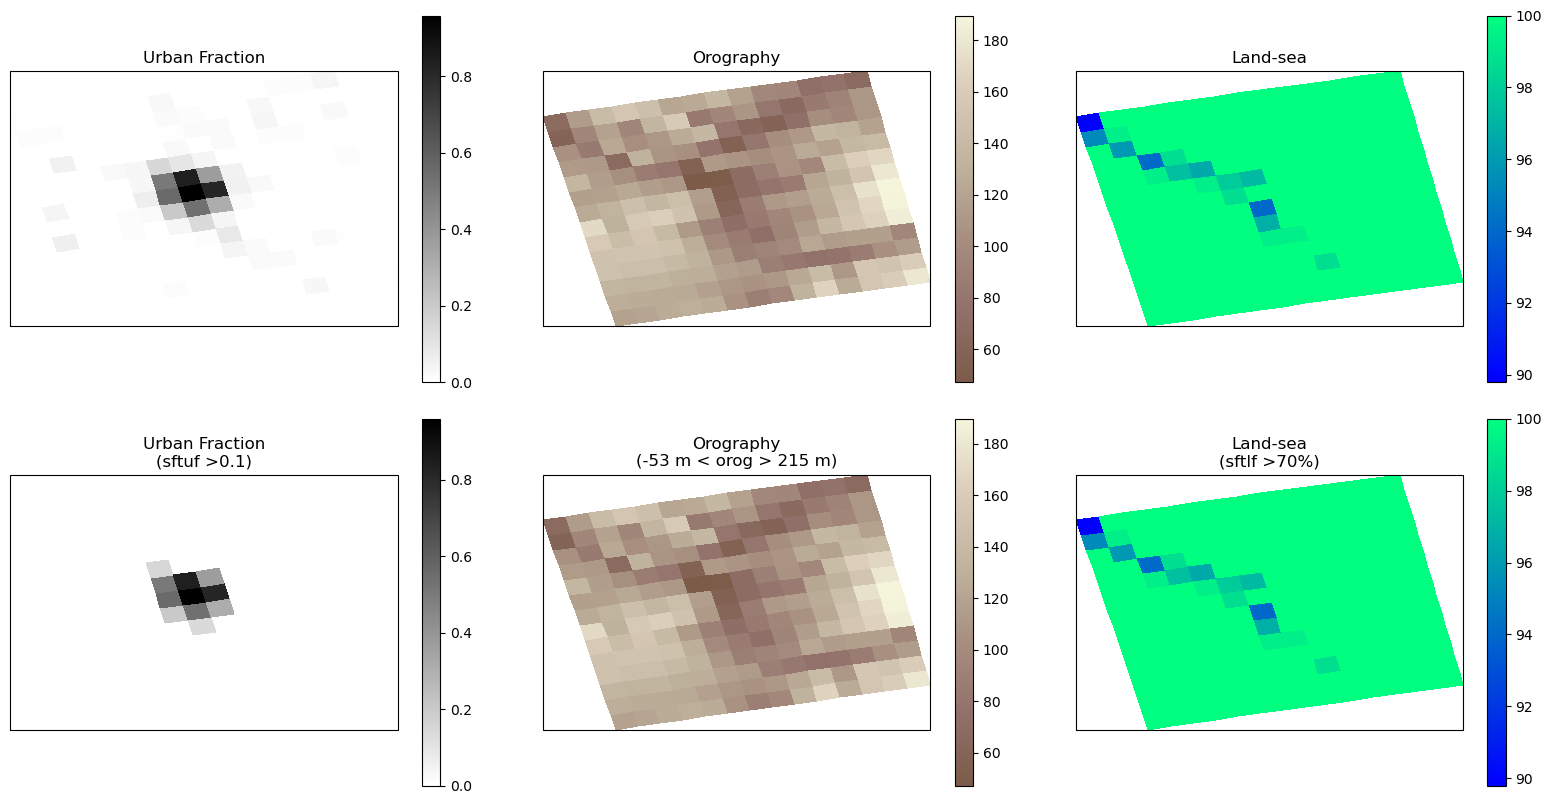

In [335]:
# plot mask
fig = URBAN.plot_fixed_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask)

#### Define rural vicinity areas

In [336]:
urban_vicinity = URBAN.select_urban_vicinity(
    sftuf_mask, 
    orog_mask,
    sftlf_mask,
    sftuf_sur_mask
)

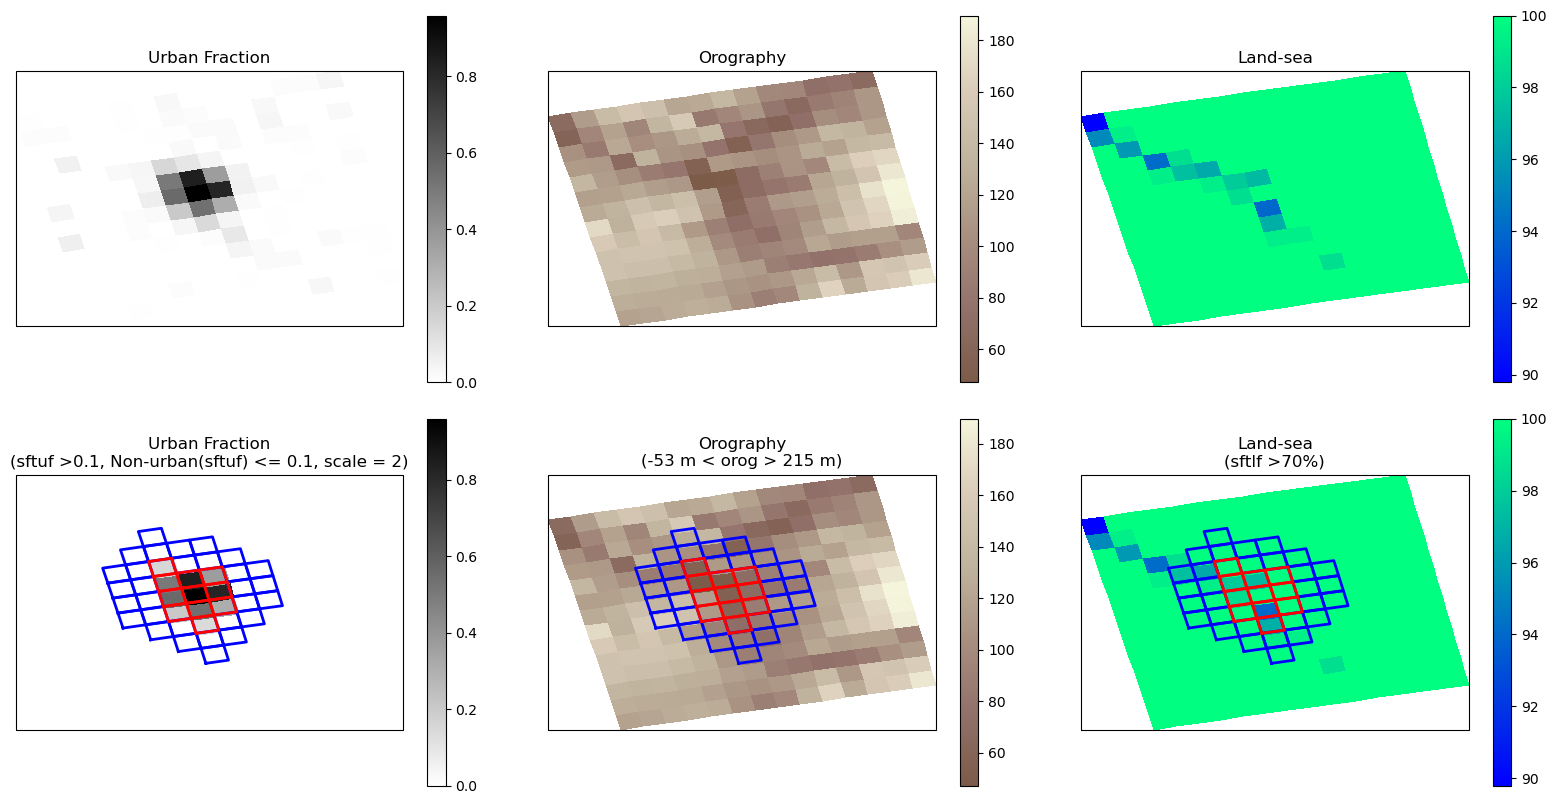

In [337]:
# plot mask and urban vs vicinity
fig = URBAN.plot_fixed_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask,
                                 urban_vicinity)

# Calculate Heat urban effect

In [372]:
variable = 'tasmin'
period = '1980-2015'
city = 'Paris'
observations = True

#### Load city shapefile

In [371]:
ucdb_city = load_ucdb_city(root_nextcloud, city)

#### Load variable from ESGF DRS

In [367]:
# load variable
ds_var = load_variable(root_esgf, variable, domain, model, scenario)
# convert to degC
ds_var = kelvin2degC(ds_var, variable)
# crop area
kelvin2degC(ds)

#### Load observations

In [ ]:
obs = load_ghcnd_stations(root, variable, city)# Yaiza: create function
    ghcnd_stations_url = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/ghcnd-stations.txt'
    ghcnd_stations_column_names = ['code', 'lat', 'lon', 'elev', 'name', 'net', 'numcode']
    ghcnd_stations_column_widths = [   11,     9,    10,      7,     34,     4,       10 ]
    df = pd.read_fwf(ghcnd_stations_url, header = 0, widths = ghcnd_stations_column_widths, names = ghcnd_stations_column_names)
    ghcnd_stations=gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs = 'EPSG:4326')
    
    rval = ghcnd_stations.assign(dist = ghcnd_stations.distance(Point(lon, lat)))
    rval.sort_values(by = 'dist', inplace = True)
    rval = rval[rval.dist < 0.5].to_crs(epsg=3857)  
    
    http://meteo.unican.es/work/chus/ghcnd/data
    
    def get_ghcnd_df(baseurl, code):
        baseurl = 'http://meteo.unican.es/work/chus/ghcnd/data'
        try:
            rval = pd.read_csv(f'{baseurl}/{code[0]}/{code}.csv.gz', compression='gzip', index_col='DATE', parse_dates=True)
        except:
            print(f'Problem downloading {code}')
            rval = pd.DataFrame()
        return(rval)

#### Select coincident time Model and Observations

In [ ]:
ds_var, obs = coincident_time(ds_var, obs, period, season)

#### Compute climatology (rural annomaly)

In [355]:
# Select the data for the specified period
ds_var_period = ds_var.sel(time=slice(period.split('-')[0], period.split('-')[1]))
# select season
# Yaiza create function (https://docs.xarray.dev/en/stable/examples/monthly-means.html)
# calcute climatology
ds_var_period_mean = ds_var_period.mean('time').compute()
# calculate mean rural temperature
rural_mean = ds_var_period_mean['tasmin'].where(urban_vicinity['urban_area'] == 0).mean().compute()
# calculate anomaly
data = ds_var_period_mean[variable] - rural_mean

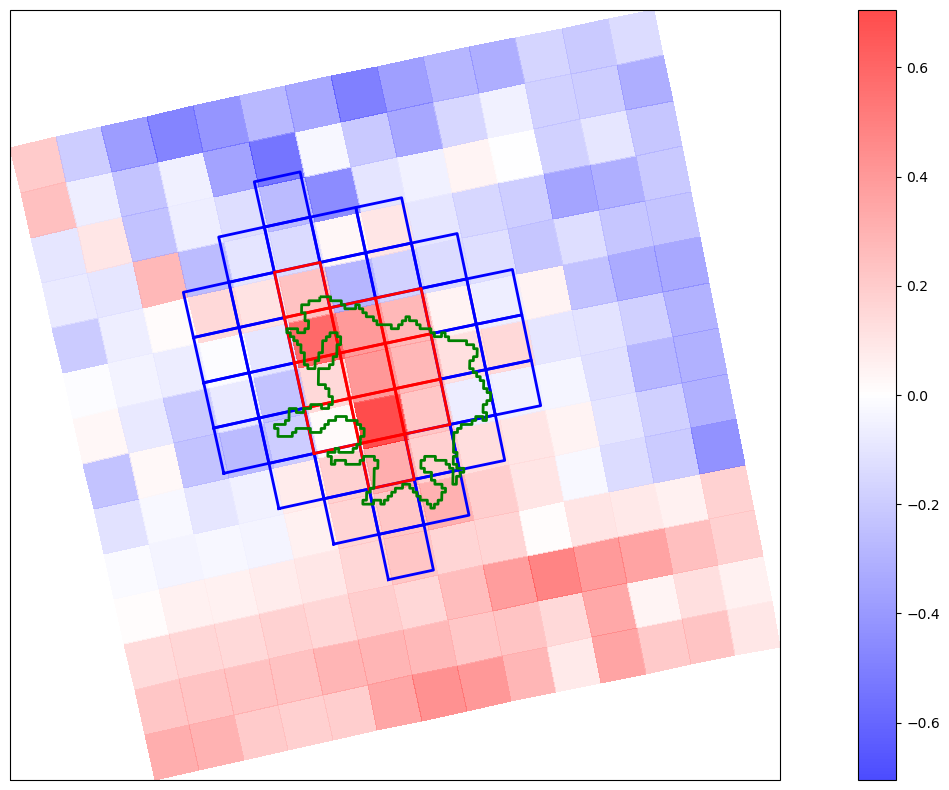

In [356]:
def plot_climatology(ds, ucdb_city, obs = None)

proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj}, figsize=(20, 10))

# Compute the maximum absolute value
max_abs_value = abs(data).max().item()

im1 = ax.pcolormesh(ds.lon, ds.lat, ds.values,
                    cmap='bwr', alpha = 0.7,
                    vmin = - max_abs_value, 
                    vmax = max_abs_value)

plt.colorbar(im1, ax = ax)

ucdb_city.plot(ax=ax, facecolor="none", transform=proj, edgecolor="Green", linewidth=2, zorder = 1000)

# Overlay the cell borders and handle NaNs
URBAN.plot_urban_borders(urban_vicinity, ax)

if obs:
    a = 1
    # Yaiza plot obs

plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Ajusta el espacio horizontal y vertical

return fig

In [172]:
data = ds_var_period[variable]

AttributeError: Rectangle.set() got an unexpected keyword argument 'marker'

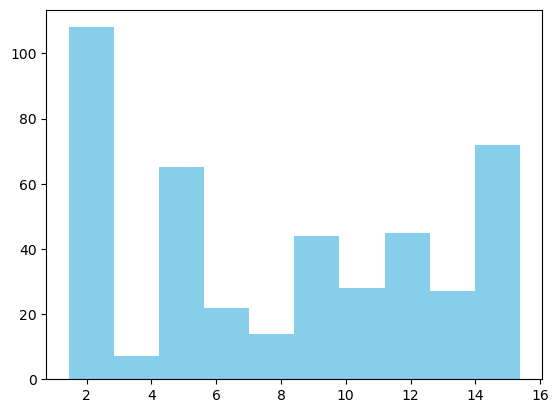

In [173]:
# Resample the data to monthly averages
monthly_data = data.resample(time='M').mean()

# Calculate the climatological monthly mean (mean for each month across all years)
climatological_monthly_mean = monthly_data.groupby('time.month').mean()

# Plot the annual cycle
fig, ax = plt.subplots()
climatological_monthly_mean.plot(ax=ax, marker='o', color='skyblue', linestyle='-', linewidth=2)

# Customize the plot
ax.set_title('Annual Cycle of Sample Data')
ax.set_xlabel('Month')
ax.set_ylabel(f'Sample Data ({data.attrs["units"]})')
ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])